In [1]:
import pandas as pd 
from scipy.io import mmread
import numpy as np
import matplotlib.pyplot as plt
from dmt import DMT
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

sns.set_style('dark')

/opt/mamba/envs/ontemn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_mtx(x_file_path, y_file_path, dtype='int32', labelencoder=False):
    x = mmread(x_file_path).astype(dtype)
    if labelencoder:
        y = pd.read_csv(y_file_path, sep='\t', header=None)
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
    else:
        y = pd.read_csv(y_file_path, sep='\t', header=None).to_numpy()
    return x, y

def get_data_info(x, y):
    ''''''
    print(f"The size of x: {len(x)}")
    print(f"The shape of x: {x.shape}")
    print(f"The size of y: {len(y)}")
    print(f"The uniques of y: {len(np.unique(y))}")

In [ ]:
# x_cel_path = "/root/ontemn/Data/celegan_preprocess.mtx"
# y_cel_em_path = "/root/ontemn/Data/celegan_embryo_time.tsv" 

# # dowsample to 10000
# X_cel, y_cel_em = read_mtx(x_cel_path, y_cel_em_path, labelencoder=True)
# downsample_size = 10000

# # Ensure that the data has at least 10,000 samples
# if X_cel.shape[0] >= downsample_size:
#     # Randomly select 10,000 indices from the data
#     indices = np.random.choice(X_cel.shape[0], downsample_size, replace=False)

#     # Use these indices to downsample X_cel and y_cel_em
#     X_cel_downsampled = X_cel[indices]
#     y_cel_em_downsampled = y_cel_em[indices]

#     # Display information of downsampled data
#     get_data_info(X_cel_downsampled, y_cel_em_downsampled)
# else:
#     print("Data has fewer than 10,000 samples; downsampling not possible.")
    


# get_data_info(X_cel_downsampled, y_cel_em_downsampled) 

dataname = 'eminst'

if dataname == 'minst':
    from torchvision.datasets import MNIST
    import torchvision.transforms as transforms

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
    ])
    train_data = MNIST(root='data', train=True, download=True, transform=transform)

    DATA = np.stack([train_data[i][0].numpy().squeeze() for i in range(len(train_data))])
    DATA = DATA.reshape((DATA.shape[0],-1))
    y_cel_em = np.array([train_data[i][1] for i in range(len(train_data))])
    
if dataname == 'eminst':
    
    from torchvision.datasets import EMNIST
    import torchvision.transforms as transforms

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
    ])
    train_data = EMNIST(root='data', train=True, download=True, transform=transform, split='byclass')

    DATA = np.stack([train_data[i][0].numpy().squeeze() for i in range(len(train_data))])
    DATA = DATA.reshape((DATA.shape[0],-1))
    y_cel_em = np.array([train_data[i][1] for i in range(len(train_data))])
    
if dataname == 'breast_cancer':
    from sklearn.datasets import load_breast_cancer
    data = load_breast_cancer()
    DATA = np.array(data.data)  # Feature matrix
    y_cel_em = np.array(data.target)  # Target vector
    


In [ ]:

DATA.shape


(697932, 784)

In [ ]:
dmt = DMT(num_fea_aim=0.99, device_id=0, epochs=300, batch_size=2000, K=5, nu=1e-2)
X_cel_dmt, X_cel_umap, X_cel_tsne, X_cel_pca  = dmt.compare(DATA, plot=None)

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | mse       | CrossEntropyLoss | 0      | train
1 | Loss      | MyLoss           | 0      | train
2 | PM_root   | Linear           | 785    | train
3 | model_pat | Sequential       | 376 K  | train
4 | model_b   | ModuleList       | 81.9 K | train
-------------------------------------------------------
459 K     Trainable params
0         Non-trainable params
459 K     Total params
1.837     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 348/348 [00:08<00:00, 40.81it/s]                

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 348/348 [00:08<00:00, 40.80it/s]


In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svc_dmt = SVC(max_iter=1e5).fit(X_cel_dmt, y_cel_em)
acc_dmt = accuracy_score(y_cel_em, svc_dmt.predict(X_cel_dmt))

svc_umap = SVC(max_iter=1e5).fit(X_cel_umap, y_cel_em)
acc_umap = accuracy_score(y_cel_em, svc_umap.predict(X_cel_umap))

svc_tsne = SVC(max_iter=1e5).fit(X_cel_tsne, y_cel_em)
acc_tsne = accuracy_score(y_cel_em, svc_tsne.predict(X_cel_tsne))

print('acc_dmt', acc_dmt)
print('acc_umap', acc_umap)
print('acc_tsne', acc_tsne)

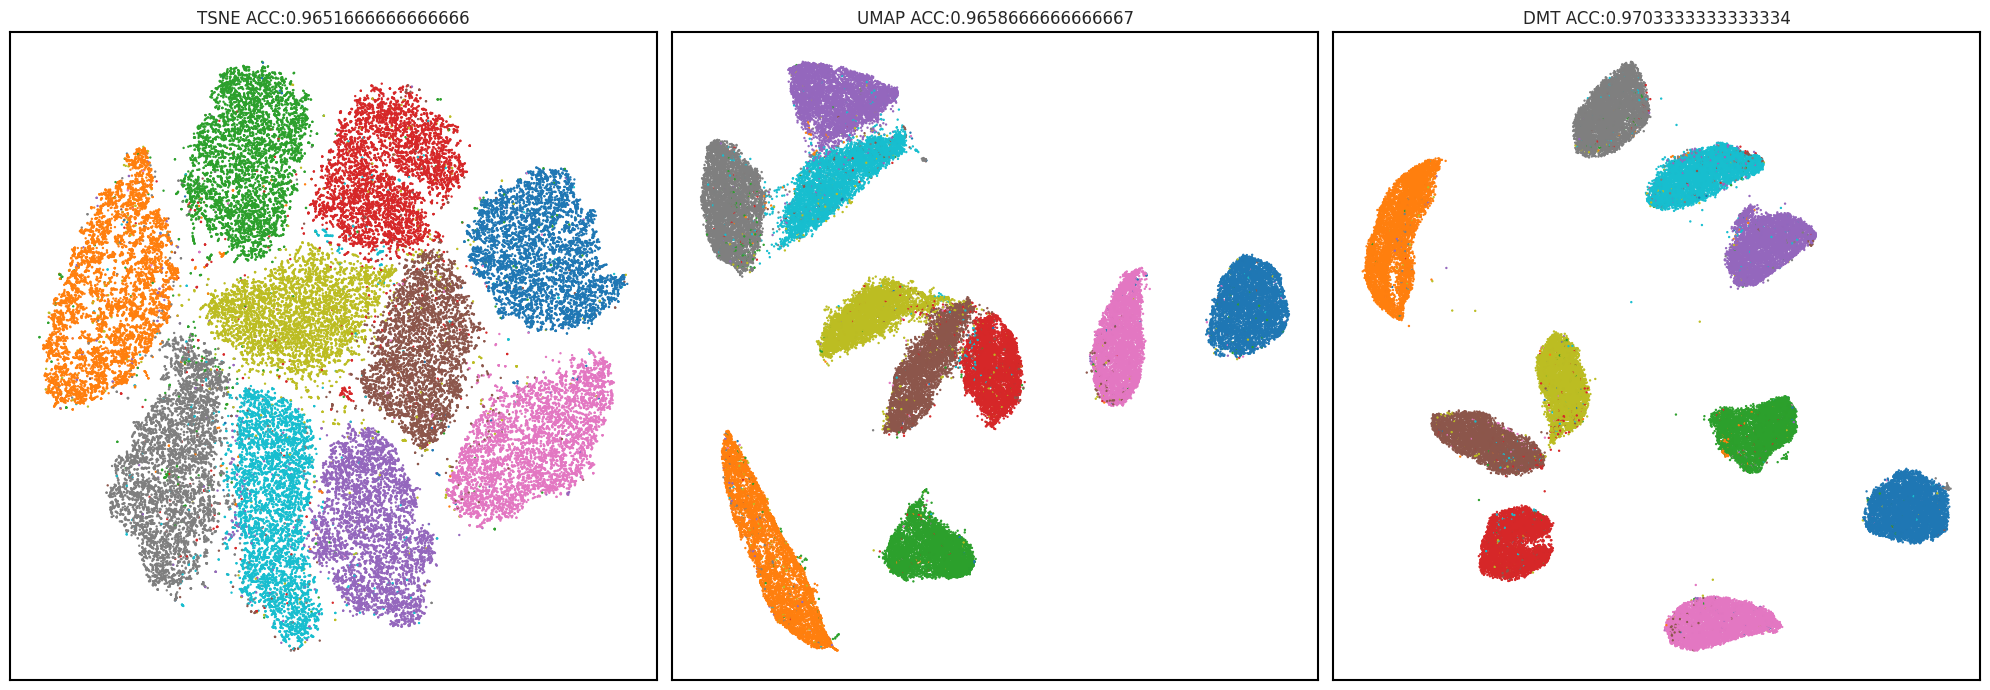

In [ ]:

plt.figure(figsize=(20, 7))

# 创建散点图
ax_1 = plt.subplot(1, 3, 3, facecolor='white')
sc1 = ax_1.scatter(X_cel_dmt[:, 0], X_cel_dmt[:, 1], c=y_cel_em, cmap='tab10', s=0.5)
ax_1.set_title(f'DMT ACC:{acc_dmt}')
ax_1.set_xticks([])  # Remove x-axis labels
ax_1.set_yticks([])  # Remove y-axis labels
ax_1.spines[:].set_color('black')  # Set border color to black
ax_1.spines[:].set_linewidth(1.5)  # Set border thickness

ax_2 = plt.subplot(1, 3, 2, facecolor='white')
sc2 = ax_2.scatter(X_cel_umap[:, 0], X_cel_umap[:, 1], c=y_cel_em, cmap='tab10', s=0.5)

ax_2.set_title(f'UMAP ACC:{acc_umap}')
ax_2.set_xticks([])  # Remove x-axis labels
ax_2.set_yticks([])  # Remove y-axis labels
ax_2.spines[:].set_color('black')  # Set border color to black
ax_2.spines[:].set_linewidth(1.5)  # Set border thickness

ax_3 = plt.subplot(1, 3, 1, facecolor='white')
sc3 = ax_3.scatter(X_cel_tsne[:, 0], X_cel_tsne[:, 1], c=y_cel_em, cmap='tab10', s=0.5)

ax_3.set_title(f'TSNE ACC:{acc_tsne}')
ax_3.set_xticks([])  # Remove x-axis labels
ax_3.set_yticks([])  # Remove y-axis labels
ax_3.spines[:].set_color('black')  # Set border color to black
ax_3.spines[:].set_linewidth(1.5)  # Set border thickness

plt.tight_layout()
plt.show()